In [136]:
from optimizers import *
from functions import *
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

#### Helper functions

In [137]:
_infty = 1e32
_zero = 1e-32

def remove_nans_infs_and_zeros(arr):
    arr = np.array(arr)
    arr[np.isnan(arr)] = _infty
    arr[np.isinf(arr)] = _infty
    arr[arr > _infty] = _infty
    arr[arr == 0] = _zero
    arr[arr < _zero] = _zero
    return arr

## A simple function

$$M = 3, K = 2, p \in \R^M, \forall_{0 \leq i < N} \, x^{[i]} \in \R^K, \, y^{[i]} \in \R$$

$$f : \R^K \times \R^M \to \R, \qquad f(x, p) = p_0^3 x_0 + p_1 x_1 + p_2 $$

$$ D_pf(x, p) = \left[\frac{\partial f}{\partial p_0}(x, p), \frac{\partial f}{\partial p_1}(x, p), \frac{\partial f}{\partial p_2}(x, p)\right]^T = [3p_0^2x_0, x_1, 1]^T$$

$$ R : \R^M \to \R^N, \qquad R(p) = \left[f(x^{[i]}, p) - y^{[i]}\right]_{0 \leq i < N} $$

$$ DR(p) = \left[\frac{\partial f}{\partial p_j}(x^{[i]}, p)\right]_{0 \leq i < N, 0 \leq j < M}$$

In [138]:
xs = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7]])
ys = np.array([1, 2, 3, 4, 5, 6])


def f(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return p[0]**3 * x[0] + p[1] * x[1] + p[2]


def df(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return np.array([3 * p[0]**2 * x[0], x[1], 1])

def ddf(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return np.array([[6 * p[0] * x[0], 0, 0], [0, 0, 0], [0, 0, 0]])


def residue(
    f: Callable[[np.ndarray, np.ndarray], np.ndarray],
    xs: np.ndarray,
    ys: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    fs = np.array([f(x, p) for x in xs])

    return fs - ys


def residue_jacobian(
    df: Callable[[np.ndarray, np.ndarray], np.ndarray],
    ys: np.ndarray,
    xs: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    dfs = np.array([df(x, p) for x in xs])

    return np.array([dfs[i] for i in range(len(xs))])

def residue_hessian(
    ddf: Callable[[np.ndarray, np.ndarray], np.ndarray],
    ys: np.ndarray,
    xs: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    ddfs = np.array([ddf(x, p) for x in xs])

    return np.array([ddfs[i] for i in range(len(xs))])

In [139]:
def R_value(p: np.ndarray) -> np.ndarray:
    return residue(f, xs, ys, p)

def R_derivative(p: np.ndarray) -> np.ndarray:
    return residue_jacobian(df, ys, xs, p)

def R_hessian(p: np.ndarray) -> np.ndarray:
    return residue_hessian(ddf, ys, xs, p)

F = Function(R_value, R_derivative, R_hessian, 3, 6)

## Performence tests

Gradient descent: 100%|██████████| 500/500 [00:00<00:00, 11367.54it/s]


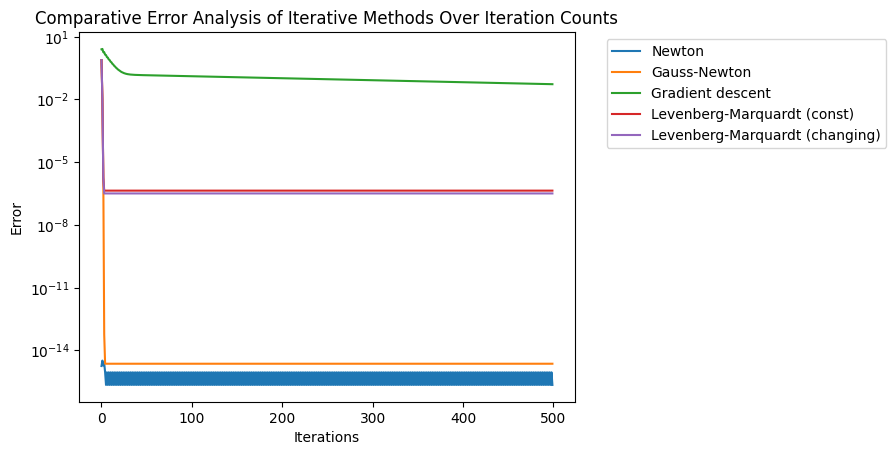

In [140]:
M = 3
max_iter = 500
p0 = np.random.randn(M)
alpha_gd = 1e-3
alpha_gn = 1.0
lambda0 = 1e-2
lambda_change = 1.1
step_max_iter = 10
step_tol = 1e-6

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []
errors_newton = []
log_interval = 1

optimizer = LevenbergMarquardt(
    R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
)
optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol, errs=errors_levenberg_marquardt_const_param, log_interval=log_interval)

optimizer = LevenbergMarquardt(
    R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=lambda_change)
)
optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol, errs=errors_levenberg_marquardt_modifying_param, log_interval=log_interval)

gauss_newton(R=F, p0=p0, alpha=alpha_gn, max_iter=max_iter, errs=errors_gauss_newton, log_interval=log_interval)
newton(R=F, p0=p0, max_iter=max_iter, alpha=alpha_gn, errs=errors_newton, log_interval=log_interval)
gradient_descent(R=F, p0=p0, alpha=alpha_gd, max_iter=max_iter, errs=errors_gradient_descent, log_interval=log_interval)

iters = np.arange(0, max_iter, log_interval)
for err, label in [
    (errors_newton, "Newton"),
    (errors_gauss_newton, "Gauss-Newton"),
    (errors_gradient_descent, "Gradient descent"),
    (errors_levenberg_marquardt_const_param, "Levenberg-Marquardt (const)"),
    (errors_levenberg_marquardt_modifying_param, "Levenberg-Marquardt (changing)"),
]:
    try:
        plt.plot(iters, err, label=label)
    except:
        print("error in plotting for " + label)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.yscale("log")
plt.title("Comparative Error Analysis of Iterative Methods Over Iteration Counts")
plt.show()